In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

%matplotlib notebook
import matplotlib.pylab as plt
# pylab.rcParams['figure.figsize'] = (10, 5)

In [227]:
import ld_gan
import numpy as np
from tqdm import tqdm
from scipy.stats import entropy
from torch.autograd import Variable

In [3]:
X, Y = ld_gan.data_proc.data_loader.load_data(1, verbose=1, resize = 64)

100%|██████████| 102/102 [00:25<00:00,  6.39it/s]

load data from '/export/home/oblum/projects/ls_gan/data/flowers_102/jpg_128'


# get point cloud data

In [4]:
def get_point_cloud(X, project, epoch):
    enc = ld_gan.utils.model_handler.load_model(project, epoch, "enc")
    z_enc = ld_gan.utils.model_handler.apply_model(enc, X, 100)
    return z_enc

In [9]:
def get_tsne_pts(project, epoch, n_pts_tsne=4000):
    epoch_str = str(epoch).zfill(4)
    fname = "projects/" + project + "/tsne_pts/" \
                      + epoch_str + "_" + str(n_pts_tsne) + ".npy"
    z_mapped = np.load(fname)
    return z_mapped

In [58]:
project, epoch = "xf_11111.py", 150
z_mapped_1 = get_tsne_pts(project, epoch)
z_1 = get_point_cloud(X, project, epoch)

project, epoch = "xf_11111.py", 400
z_mapped_2 = get_tsne_pts(project, epoch)
z_2 = get_point_cloud(X, project, epoch)

loaded model 'projects/xf_11111.py/model/e_0150.pth'
loaded model 'projects/xf_11111.py/model/e_0400.pth'


<IPython.core.display.Javascript object>


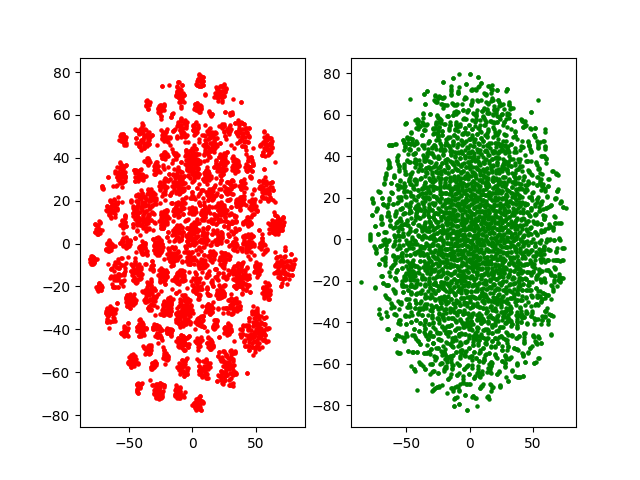

In [117]:
plt.figure()
plt.title("tsne of latent space")
plt.subplot(1,2,1)
plt.scatter(z_mapped_1[:,0], z_mapped_1[:,1], s=5, c='r')
plt.subplot(1,2,2)
plt.scatter(z_mapped_2[:,0], z_mapped_2[:,1], s=5, c='g')
plt.show()

In [15]:
from sklearn.neighbors.kde import KernelDensity

In [146]:
std_1 = []
std_2 = []
e_1 = []
e_2 = []

batchsize = 256
bws = np.linspace(4, 6, 20)
idxs = np.random.randint(0, len(X), batchsize)
for i in tqdm(bws):
    kde_1 = KernelDensity(bandwidth=i).fit(z_1)
    kde_2 = KernelDensity(bandwidth=i).fit(z_2)

    k1 = kde_1.score_samples(z_1[idxs])
    k2 = kde_2.score_samples(z_2[idxs])
    
    e_1.append(entropy(k1))
    e_2.append(entropy(k2))
    
    std_1.append(np.std(k1))
    std_2.append(np.std(k2))

100%|██████████| 20/20 [00:57<00:00,  2.92s/it]


<IPython.core.display.Javascript object>


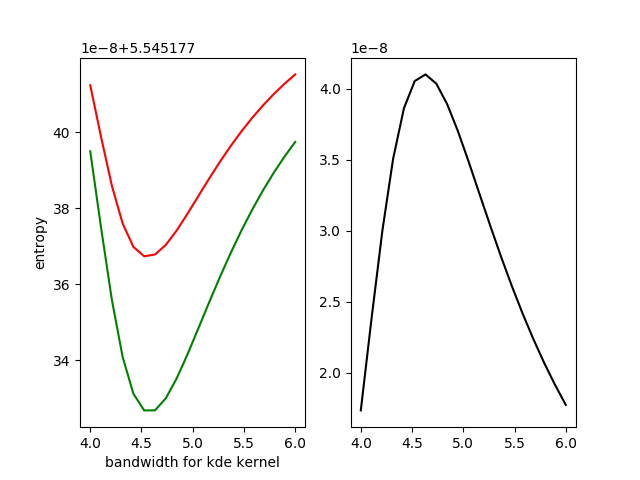

4.52631578947
4.52631578947
4.42105263158


In [150]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(bws, e_1, c='r')
plt.plot(bws, e_2, c='g')
plt.ylabel("entropy")
plt.xlabel("bandwidth for kde kernel")

plt.subplot(1,2,2)
plt.plot(bws, np.array(e_1)-np.array(e_2), c='k')

plt.show()

print bws[np.argmin(e_1)]
print bws[np.argmin(e_2)]
print bws[np.argmax(d)]

# variance

In [151]:
print np.std(z_1)
print np.std(z_2)

0.794434
0.794543


# pytorch

In [152]:
import torch

In [249]:
bw = 4.5

z_all = ld_gan.data_proc.transform(z_1)
z_all = torch.squeeze(z_all)
z_batch = z_all[:256]

In [219]:
a = np.random.rand(256)
a = a / a.sum()

b = np.random.rand(256)
b = b / b.sum()

a.dot(b.transpose())

0.0040859275907163765

In [243]:
dist_mat = torch.mm(z_all, z_batch.t())
dist_norm = (z_batch * z_batch).sum(1)
dist_mat = dist_norm - dist_mat

In [250]:
gaus_mat = torch.exp(- dist_mat / bw)

In [253]:
err = torch.mean(gaus_mat)

In [254]:
err

Variable containing:
1.00000e-04 *
  1.2331
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [ ]:
def entropy_loss(z_all, z_batch):
    